In [22]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from dltool import dataprocess
import dltool.train as dlTrain

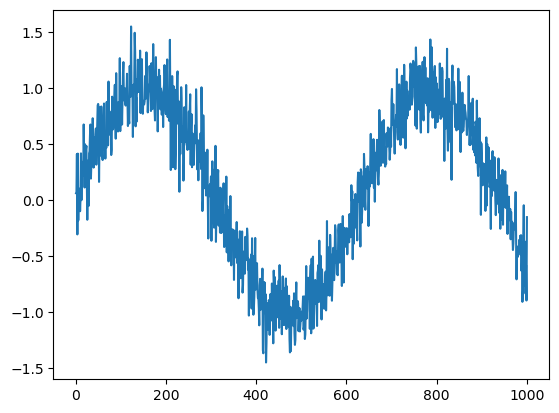

In [23]:
T = 1000 # 总共产生1000个点
time = torch.arange(1,T+1,dtype=torch.float32)
x = torch.sin(0.01 * time) + torch.normal(0,0.2,(T,))
plt.plot(time, x)


生成数据对：将序列转换为特征-标签的对子

In [24]:
tau = 4
features = torch.zeros((T-tau,tau))
for i in range(tau):
  features[:,i] = x[i:T-tau+i]
print(features.shape)
labels = x[tau:].reshape((-1,1))
batch_size, n_train = 16, 600
# 只有前n_train个样本用于训练
train_iter = dataprocess.load_array((features[:n_train], labels[:n_train]),
                                    batch_size, is_train=True)

torch.Size([996, 4])


两个全连接层的MLP、ReLU

In [25]:
def init_weights(m):
  if type(m) == nn.Linear:
    nn.init.xavier_uniform_(m.weight)

def get_net():
  net = nn.Sequential(nn.Linear(4,10),
                      nn.ReLU(),
                      nn.Linear(10,1))
  net.apply(init_weights)
  return net

loss = nn.MSELoss(reduction='none')

In [26]:
class Accumulator:
    """在n个变量上累加"""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self,*args):
        self.data = [a + float(b) for a,b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]
      
def evaluate_loss(net, data_iter, loss):
  """评估给定数据集上模型的损失"""
  metric = Accumulator(2) # 损失的总和、样本数量
  for X, y in data_iter:
    out = net(X)
    y = y.reshape(out.shape)
    l = loss(out, y)
    metric.add(l.sum(), l.numel())
  return metric[0] / metric[1]

In [27]:
def train(net, train_iter, loss, epochs, lr):
  trainer = torch.optim.Adam(net.parameters(), lr)
  for epoch in range(epochs):
    for X,y in train_iter:
      trainer.zero_grad()
      l = loss(net(X),y)
      l.sum().backward()
      trainer.step()
    print(f'epoch {epoch + 1},'
          f'loss: {evaluate_loss(net, train_iter, loss):f}')

net = get_net()
train(net, train_iter, loss, 9, 0.01)

epoch 1,loss: 0.073210
epoch 2,loss: 0.061506
epoch 3,loss: 0.059926
epoch 4,loss: 0.058075
epoch 5,loss: 0.056266
epoch 6,loss: 0.056038
epoch 7,loss: 0.055511
epoch 8,loss: 0.054513
epoch 9,loss: 0.054699


# 预测

单步预测，预测下一个时间步。

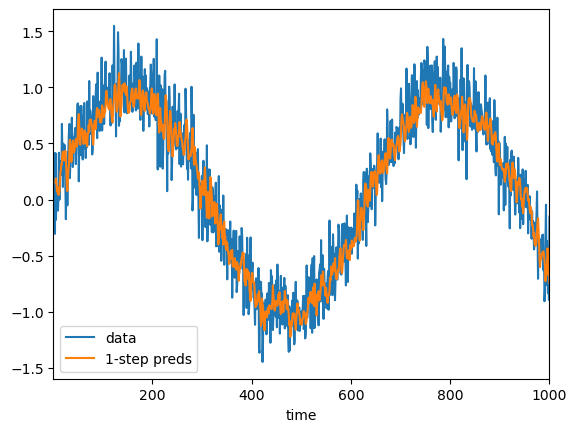

In [28]:
onestep_preds = net(features)
# plt.plot([time, time[tau:]],
#          [x.detach().numpy(), onestep_preds.detach().numpy()])
plt.figure()
plt.plot(time, x.detach().numpy(),label='data')
plt.plot(time[tau:],onestep_preds.detach().numpy(),label='1-step preds')
plt.xlabel('time')
plt.xlim(1,1000)
plt.legend()
plt.show()


多步预测

In [29]:
multistep_preds = torch.zeros(T)
multistep_preds[: n_train + tau] = x[:n_train + tau]
for i in range(n_train + tau, T):
  multistep_preds[i] = net(
    multistep_preds[i-tau:i].reshape((1,-1))
  )

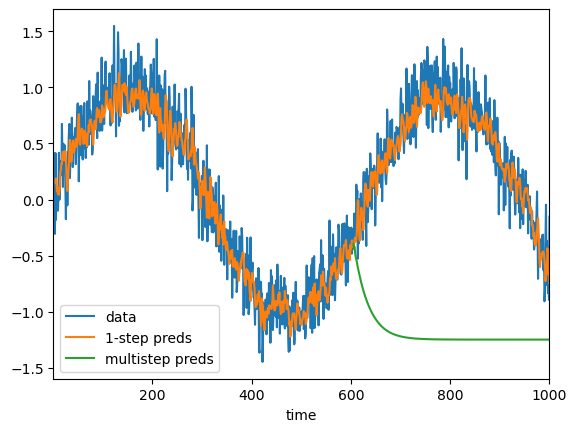

In [30]:
plt.figure()
plt.plot(time, x.detach().numpy(),label='data')
plt.plot(time[tau:],onestep_preds.detach().numpy(),label='1-step preds')
plt.plot(time[n_train+tau:],multistep_preds[n_train+tau:].detach().numpy(), label='multistep preds')
plt.xlabel('time')
plt.xlim(1,1000)
plt.legend()
plt.show()

多步预测效果并不理想，因为错误累积。